In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.feature_selection import RFECV, SequentialFeatureSelector, VarianceThreshold
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, RFECV

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

from regression_scores import calculate_scores, calculate_score

# Initial data Exploration

In [4]:
df_unprocessed_validation = pd.read_csv('data/test.csv') 

df_unprocessed = pd.read_csv('data/train.csv') 
df_unprocessed

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,

In [5]:
df_unprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
df_unprocessed.isnull().sum()[df_unprocessed.isnull().sum()>0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [7]:
numerical_features = df_unprocessed.select_dtypes(include=['int', 'float']).columns
categorical_features = df_unprocessed.select_dtypes(include=['object', 'category']).columns

In [8]:
df_unprocessed.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


**Some clues for outliers:**  
- Lot Area  
- MasVnrArea
...

In [9]:
df_unprocessed[categorical_features].describe().T

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


# Data Preprocessing

In [10]:
def fill_missing_values(df):
    col_fillna_0 = ['MasVnrArea', 'LotFrontage', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                    'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']
    col_fillna_mode = ['MSZoning', 'Functional', 'Utilities', 'Exterior2nd', 'Exterior1st', 'SaleType', 'KitchenQual']
    col_fillna_const = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageFinish', 
                        'GarageQual', 'GarageCond', 'GarageType', 'BsmtExposure', 'BsmtCond', 
                        'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'Electrical', 'MasVnrType']

    # Fill missing values with 0 for numeric columns
    df[col_fillna_0] = df[col_fillna_0].fillna(0)

    # Fill missing values with the most frequent value for categorical columns
    for column in col_fillna_mode + col_fillna_const:
        most_frequent_value = df[column].mode().iloc[0]
        df[column] = df[column].fillna(most_frequent_value)

    return df

In [11]:
df = fill_missing_values(df_unprocessed)
df.sample()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1383,1384,30,RL,0.0,25339,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,7,1918,2007,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,0.0,TA,Gd,BrkTil,TA,TA,No,Unf,0,Unf,0,816,816,GasA,Ex,Y,SBrkr,1416,0,0,1416,0,0,2,0,3,1,Gd,7,Typ,0,Gd,Attchd,2007.0,Unf,2,576,TA,TA,N,0,0,112,0,0,0,Gd,MnPrv,Shed,0,8,2007,WD,Normal,112000


In [12]:
def years(df):
    # Create Age of the House / drop 'YearBuilt'
    df['Age_of_Property'] = (df['YearBuilt'].max() - df['YearBuilt']).astype(int)

    # Create 'Age_of_Renovation' / drop 'YearRemodAdd'
    df['Age_of_Renovation'] = (df['YearBuilt'].max() - df['YearRemodAdd']).astype(int)
    
    # Create 'Age_of_Renovation' / drop 'YearRemodAdd'
    df['Age_of_Garage'] = (df['YearBuilt'].max() - df['GarageYrBlt']).astype(int)
    
    df.drop(columns=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], inplace=True)
    
    return df

In [13]:
df = years(df)
df.sample()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age_of_Property,Age_of_Renovation,Age_of_Garage
624,625,60,RL,80.0,10400,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,6,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,288.0,TA,TA,CBlock,TA,TA,No,Rec,247,Unf,0,485,732,GasA,Gd,Y,SBrkr,1012,778,0,1790,1,0,1,2,4,1,TA,8,Min2,1,TA,Attchd,RFn,2,484,TA,TA,Y,148,0,0,0,147,0,Gd,MnPrv,Shed,0,11,2006,WD,Normal,165150,38,38,38


In [14]:
def areas(df):
    
    # Create Total Bathrooms / drop 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'
    df['Total_Bathrooms'] = df['BsmtFullBath'] + df['FullBath'] + 0.5*(df['BsmtHalfBath'] + df['HalfBath'])
    df.drop(columns=['BsmtFullBath',  'FullBath',  'BsmtHalfBath',  'HalfBath' ], inplace=True)
    
    # Hold 'GrLivArea' / drop '1stFlrSF', '2ndFlrSF'
    # Hold 'TotRmsAbvGrd' / drop 'BedroomAbvGr'
    df.drop(columns=['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr'], inplace=True)

    return df

In [15]:
df = areas(df)
df.sample()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age_of_Property,Age_of_Renovation,Age_of_Garage,Total_Bathrooms
1146,1147,20,RL,0.0,11200,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,6,5,Gable,CompShg,Wd Sdng,Wd Shng,BrkFace,85.0,Gd,TA,CBlock,Gd,TA,No,GLQ,1258,Unf,0,40,1298,GasA,TA,Y,SBrkr,0,1298,1,Gd,5,Typ,1,TA,Attchd,Unf,2,403,TA,TA,Y,165,26,0,0,0,0,Gd,MnPrv,Shed,0,5,2006,WD,Normal,180000,25,25,25,3.0


In [16]:
def garage(df):
    
    #create 'Has_Garage' binary 
    df['HasGarage'] = (df['GarageType'] != 'No Attribute').astype(int)   
    
    # Hold 'GarageArea',/ drop 'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond'
    df.drop(columns=['GarageType','Age_of_Garage','GarageFinish','GarageCars','GarageQual','GarageCond'], inplace=True)
    
    return df

In [17]:
df = garage(df)
df.sample()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age_of_Property,Age_of_Renovation,Total_Bathrooms,HasGarage
1043,1044,60,RL,86.0,11839,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,Hip,CompShg,HdBoard,HdBoard,BrkFace,99.0,TA,TA,PConc,Gd,TA,No,GLQ,1085,Unf,0,390,1475,GasA,Ex,Y,SBrkr,0,2329,1,Gd,10,Typ,1,Ex,514,Y,192,121,0,0,0,0,Gd,MnPrv,Shed,0,5,2008,WD,Normal,262280,20,20,3.5,1


In [18]:
def basement(df):
    # Define different mappings for each basement feature
    mappings = {
        'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Basement': 0},
        'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Basement': 0},
        'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'No Basement': 0},
        'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'No Basement': 0},
        'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'No Basement': 0},
    }

    # Map categorical values to numeric grades
    for feature, mapping in mappings.items():
        df[feature] = df[feature].map(mapping)

    # Calculate BsmtFinGrade without zero-division issues
    mask = df['TotalBsmtSF'] != 0
    df_masked = df[mask]
    df['BsmtFinGrade'] = (df_masked['BsmtFinType1'] * df_masked['BsmtFinSF1'] / df_masked['TotalBsmtSF']) + \
                         (df_masked['BsmtFinType2'] * df_masked['BsmtFinSF2'] / df_masked['TotalBsmtSF']) + \
                         (df_masked['BsmtFinType1'] * df_masked['BsmtUnfSF'] / df_masked['TotalBsmtSF'])
    
    # Because of zero division there will be Nan values where there are no basement, since TotalBsmtSf == 0
    df['BsmtFinGrade'].fillna(0.0, inplace=True)
    
    # Calculate BsmtOverallGrade
    df['BsmtOverallGrade'] = round((df['BsmtQual'] + df['BsmtCond'] + 1.5*df['BsmtExposure'] + df['BsmtFinGrade']), 2)

    # Drop the unnecessary columns
    df.drop(columns=['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFinGrade'], inplace=True)

    return df


In [19]:
df = basement(df)
df.sample()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age_of_Property,Age_of_Renovation,Total_Bathrooms,HasGarage,BsmtOverallGrade
994,995,20,RL,96.0,12456,Pave,Grvl,Reg,Lvl,AllPub,FR2,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,Hip,CompShg,CemntBd,CmentBd,Stone,230.0,Ex,TA,PConc,1700,GasA,Ex,Y,SBrkr,0,1718,1,Ex,7,Typ,1,Gd,786,Y,216,48,0,0,0,0,Gd,MnPrv,Shed,0,7,2009,WD,Normal,337500,4,3,3.0,1,20.0


In [20]:
def terrace(df):
    # Create 'Terrace_Grade' / drop 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'
    terrace_columns = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
    terrace_weights = [1, 1, 2, 2, 2]

    df['Terrace_Grade'] = np.dot(df[terrace_columns], terrace_weights)
    
    # Drop the rest
    df.drop(columns=['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], inplace=True)
    
    return df

In [21]:
df = terrace(df)
df.sample()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age_of_Property,Age_of_Renovation,Total_Bathrooms,HasGarage,BsmtOverallGrade,Terrace_Grade
418,419,50,RL,60.0,8160,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,5,6,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.0,TA,TA,BrkTil,756,GasA,Fa,N,FuseF,0,1134,1,TA,7,Typ,0,Gd,240,P,0,Gd,MnPrv,Shed,0,4,2007,WD,AdjLand,126000,70,60,2.5,1,12.5,0


In [22]:
# we need to hard code this

neighborhood_median_price = df_unprocessed.groupby('Neighborhood')['SalePrice'].median().reset_index()
neighborhood_median_price.columns = ['Neighborhood', 'MedianHousePrice']

In [23]:
def neighborhood(df):

    df1 = pd.merge(df, neighborhood_median_price, on='Neighborhood', how='left')
    df1.drop(columns=['Neighborhood'], inplace=True)
    
    return df1

In [24]:
df = neighborhood(df)
df.sample()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age_of_Property,Age_of_Renovation,Total_Bathrooms,HasGarage,BsmtOverallGrade,Terrace_Grade,MedianHousePrice
821,822,20,RM,60.0,6000,Pave,Pave,Reg,Bnk,AllPub,Inside,Mod,Norm,Norm,2fmCon,1Story,4,4,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.0,Fa,TA,CBlock,936,GasA,TA,N,SBrkr,0,936,1,TA,4,Min2,0,Gd,576,Y,0,Gd,MnPrv,Shed,0,2,2009,WD,Normal,93000,57,57,1.0,1,7.5,256,119000.0


In [25]:
def detect_cardinality(df, columns, threshold_low=0.1, threshold_high=0.9, drop=False):
    cardinality_columns = []
    # loop through the given columns
    for col in columns:
        #calculate value counts and focus on the maximum frequency
        val_count = df[col].value_counts(normalize=True).sort_values(ascending=False).reset_index()
        value, freq = val_count.iloc[0]
        
        # if freq is too much --> no variance, too low-->too much variance
        if (freq > threshold_high) or (freq < threshold_low):
            cardinality_columns.append(col)
            print(f"{col.ljust(15)} -- {str(value).ljust(15)} -- {freq}")
    
    if drop:
        df.drop(columns=cardinality_columns, inplace=True)
        print(f"{len(cardinality_columns)} columns were dropped from dataset")
        return df
    else:
        return cardinality_columns

In [26]:
df.drop(columns=['Id', 'LotArea'], inplace=True)

In [27]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns

df = detect_cardinality(df, categorical_features, drop=True)
df.sample()

Street          -- Pave            -- 0.9958904109589041
Alley           -- Grvl            -- 0.9719178082191781
Utilities       -- AllPub          -- 0.9993150684931507
LandSlope       -- Gtl             -- 0.9465753424657535
Condition2      -- Norm            -- 0.9897260273972602
RoofMatl        -- CompShg         -- 0.9821917808219178
MasVnrType      -- BrkFace         -- 0.9020547945205479
Heating         -- GasA            -- 0.9780821917808219
CentralAir      -- Y               -- 0.934931506849315
Electrical      -- SBrkr           -- 0.9143835616438356
Functional      -- Typ             -- 0.9315068493150684
PavedDrive      -- Y               -- 0.9178082191780822
PoolQC          -- Gd              -- 0.9972602739726028
Fence           -- MnPrv           -- 0.915068493150685
MiscFeature     -- Shed            -- 0.9965753424657534
15 columns were dropped from dataset


,MSSubClass,MSZoning,LotFrontage,LotShape,LandContour,LotConfig,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,LowQualFinSF,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageArea,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age_of_Property,Age_of_Renovation,Total_Bathrooms,HasGarage,BsmtOverallGrade,Terrace_Grade,MedianHousePrice
927,60,RL,0.0,Reg,Lvl,Inside,Feedr,1Fam,2Story,7,5,Gable,MetalSd,MetalSd,342.0,TA,TA,CBlock,832,Gd,0,1978,1,TA,9,1,Gd,486,0,0,4,2008,WD,Normal,176000,42,42,2.5,1,11.5,43,182900.0


In [28]:
ordinal_mapping = {
    'Street': {'Grvl':1, 'Pave':2},
    'Alley' : {'Grvl':1, 'Pave':2, 'No Alley Access':0},
    'LotShape' : {'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4 },
    'LandContour' : {'Low':1, 'HLS':2, 'Bnk':3, 'Lvl':4 },
    'LandSlope' : {'Sev':1, 'Mod':2, 'Gtl':3},
    'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Basement': 0},
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Basement': 0},
    'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No':1, 'No Basement': 0},
    'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'No Basement': 0},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'No Basement': 0},    
    'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No FirePlace': 0},
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Garage': 0},
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Garage': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'No Garage': 0},
    'PavedDrive': {'Y': 3, 'P': 2, 'N': 1},
    'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'No Pool': 0},
    'Fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'No Fence': 0},        
    'Functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},
    'CentralAir': {'Y': 1, 'N': 0},
    'Foundation': {'BrkTil':2, 'CBlock':2,'PConc':3,'Slab':3, 'Stone':2, 'Wood':1}
}

In [29]:
df['MSSubClass'] = df.MSSubClass.astype('object')

In [30]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns

# Apply Ordinal Encoding
for var in categorical_features:
    if var in ordinal_mapping.keys():
        df[var] = df[var].map(ordinal_mapping[var])

In [31]:
df.sample()

,MSSubClass,MSZoning,LotFrontage,LotShape,LandContour,LotConfig,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,LowQualFinSF,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageArea,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age_of_Property,Age_of_Renovation,Total_Bathrooms,HasGarage,BsmtOverallGrade,Terrace_Grade,MedianHousePrice
675,160,RL,24.0,4,4,Inside,Norm,Twnhs,2Story,6,6,Gable,Plywood,Brk Cmn,0.0,3,3,2,855,3,0,1441,1,3,7,1,3,440,0,0,4,2009,WD,Normal,148500,32,32,2.5,1,12.5,28,146000.0


# Exploratory Data Analysis 

## Numerical Features

In [32]:
df.shape

(1460, 42)

In [33]:
numerical_features = df.select_dtypes(include=['number']).columns
categorical_features = df.select_dtypes(include=['object', 'category']).columns

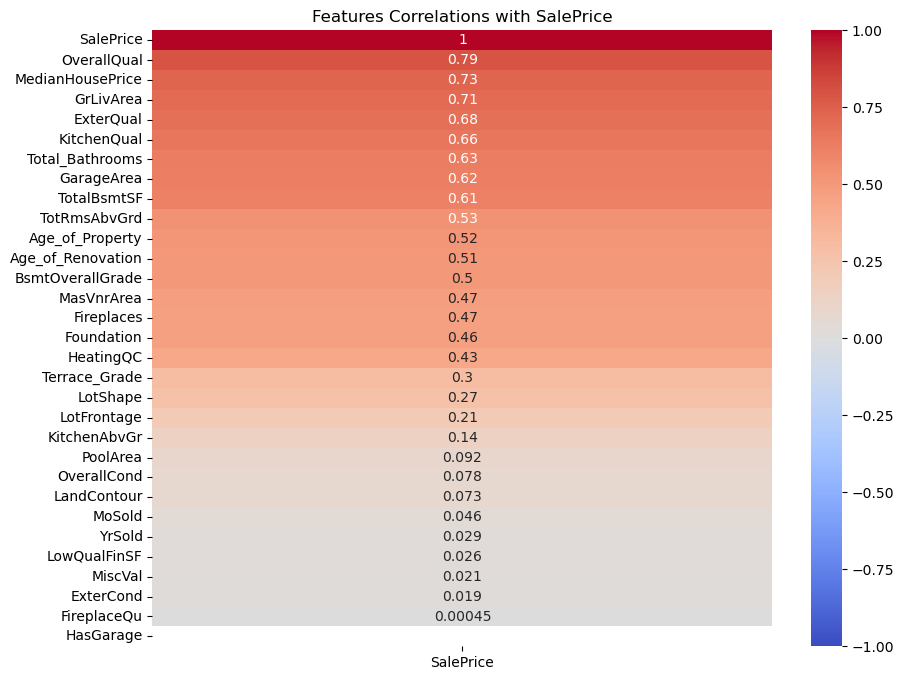

In [34]:
target_column = 'SalePrice'
corr_matrix = df[numerical_features].corr()
corr_with_target = corr_matrix[target_column].apply(np.abs).sort_values(ascending=False)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title(f'Features Correlations with {target_column}')
plt.show()

# Model Building & Evaluation

In [35]:
target = 'SalePrice'
X = df.drop(columns=target)
# y = df[target]
y = np.log1p(df[target])

In [36]:
X.head(5)

,MSSubClass,MSZoning,LotFrontage,LotShape,LandContour,LotConfig,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,LowQualFinSF,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageArea,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Age_of_Property,Age_of_Renovation,Total_Bathrooms,HasGarage,BsmtOverallGrade,Terrace_Grade,MedianHousePrice
0,60,RL,65.0,4,4,Inside,Norm,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,196.0,4,3,3,856,5,0,1710,1,4,8,0,4,548,0,0,2,2008,WD,Normal,7,7,3.5,1,14.5,61,197200.0
1,20,RL,80.0,4,4,FR2,Feedr,1Fam,1Story,6,8,Gable,MetalSd,MetalSd,0.0,3,3,2,1262,5,0,1262,1,3,6,1,3,460,0,0,5,2007,WD,Normal,34,34,2.5,1,18.0,298,218000.0
2,60,RL,68.0,3,4,Inside,Norm,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,162.0,4,3,3,920,5,0,1786,1,4,6,1,3,608,0,0,9,2008,WD,Normal,9,8,3.5,1,16.0,42,197200.0
3,70,RL,60.0,3,4,Corner,Norm,1Fam,2Story,7,5,Gable,Wd Sdng,Wd Shng,0.0,3,3,2,756,4,0,1717,1,4,7,1,4,642,0,0,2,2006,WD,Abnorml,95,40,2.0,1,13.5,579,200624.0
4,60,RL,84.0,3,4,FR2,Norm,1Fam,2Story,8,5,Gable,VinylSd,VinylSd,350.0,4,3,3,1145,5,0,2198,1,4,9,1,3,836,0,0,12,2008,WD,Normal,10,10,3.5,1,17.5,276,301500.0


In [37]:
y.sample(3)

281    12.128117
0      12.247699
195    11.908347
Name: SalePrice, dtype: float64

In [38]:
# Train - test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1314, 41)
(1314,)
(146, 41)
(146,)


In [39]:
algorithms_scaled_data = [
    LinearRegression(),
    SVR(),
    LassoCV()
]

algorithms_tree_based = [
    XGBRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42)
]

algorithms = algorithms_scaled_data + algorithms_tree_based

In [43]:
numerical_features = X.select_dtypes(include=['number']).columns.to_list()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.to_list()

print(numerical_features)
print('-'*50)
print(categorical_features)

['LotFrontage', 'LotShape', 'LandContour', 'OverallQual', 'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'TotalBsmtSF', 'HeatingQC', 'LowQualFinSF', 'GrLivArea', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageArea', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'Age_of_Property', 'Age_of_Renovation', 'Total_Bathrooms', 'HasGarage', 'BsmtOverallGrade', 'Terrace_Grade', 'MedianHousePrice']
--------------------------------------------------
['MSSubClass', 'MSZoning', 'LotConfig', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'SaleType', 'SaleCondition']


In [44]:
pipelines = {}

# Create transformers for numerical and categorical columns
scaler = StandardScaler()
ohe_encoder = OneHotEncoder(handle_unknown='ignore')
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

for algorithm in algorithms:
    
    # extract algorithm name as a string
    algorithm_name = algorithm.__class__.__name__

pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
                                        transformers=[
                                                        ('ordinal', ordinal_encoder, categorical_features),
                                                        ('passthrough', 'passthrough', numerical_features)
                                                     ],
                                        remainder='drop'))
]
)
    
    # make pipelines for algorithms need scaling and onehotencoding (defined in preprocessor)
    if algorithm in algorithms_scaled_data:
        pipeline = Pipeline(steps=[
            ('preprocessor1', preprocessor1),
            (algorithm_name, algorithm)])

    # make pipelines for tree based algorithms (no need for scaling and onehot encoding, but only ordinalencoding)
    else:
        pipeline = Pipeline(steps=[
            ('preprocessor2', preprocessor2),
            (algorithm_name, algorithm)
        ])
    
    # REUSABLE models
    # fill the dictionary with algo names and their corresponding pipelines for using later
    pipelines[algorithm_name] = pipeline

# For Example
pipelines['XGBRegressor']

Pipeline(steps=[('preprocessor2',
                 ColumnTransformer(transformers=[('cat_ord',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['MSSubClass', 'MSZoning',
                                                   'LotConfig', 'Condition1',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'Exterior1st',
                                                   'Exterior2nd', 'SaleType',
                                                   'SaleCondition'])])),
                ('XGBRegressor',
                 XGBReg...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [46]:
compare_results = calculate_scores(pipelines, X_train, X_test, y_train, y_test)
compare_results

,Linea_train,Linea_test,Linea_CV,SVR_train,SVR_test,SVR_CV,Lasso_train,Lasso_test,Lasso_CV,XGBRe_train,XGBRe_test,XGBRe_CV,Gradi_train,Gradi_test,Gradi_CV
R2,0.885652,-8.746843e+22,-5.199297e+21,0.958606,0.877441,0.858351,0.896042,0.933310,0.870702,0.803543,0.540888,0.439895,0.616264,0.575849,0.485644
-mae,0.094150,1.876740e+10,-1.287389e+09,0.065552,0.100427,-0.097898,0.085298,0.084874,-0.091160,0.112667,0.229349,-0.215470,0.183488,0.227403,-0.210101
-mse,0.017767,1.714115e+22,-7.350918e+20,0.006432,0.024018,-0.022280,0.016153,0.013069,-0.020487,0.030525,0.089972,-0.086590,0.059624,0.083121,-0.079556
-rmse,0.133293,1.309242e+11,-1.643957e+10,0.080197,0.154977,-0.147628,0.127093,0.114321,-0.140319,0.174714,0.299953,-0.294027,0.244179,0.288307,-0.281669


In [77]:
model_xgb = pipelines['XGBRegressor']
model_xgb.fit(X,y)

y_train_pred = model_xgb.predict(X_train)
y_pred = model_xgb.predict(X_test)

calculate_score(y_train, y_train_pred, y_test, y_pred, 'XGB')

Error calculating CV scores: 'NoneType' object has no attribute 'mean'


,XGB_train,XGB_test
R2,0.793128,0.761412
-mae,0.117907,0.146980
-mse,0.032143,0.046756
-rmse,0.179285,0.216231


# RFECV

In [78]:
# Initialize XGBoost regressor
xgb_model = XGBRegressor()

# Initialize RFECV with XGBoost model and cross-validation strategy
rfecv = RFECV(estimator=xgb_model, step=1, cv=5, scoring='neg_mean_squared_error')

# Fit RFECV on the training data
rfecv.fit(X_train, y_train)

# Plot the number of features vs. cross-validation scores
plt.figure(figsize=(10, 6))
plt.title('RFECV with XGBoost')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validation Score (neg MSE)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker='o', linestyle='-', color='b')
plt.show()

# Print the optimal number of features
print("Optimal number of features: {}".format(rfecv.n_features_))

# Get the selected features
selected_features = X_train.columns[rfecv.support_]
print("Selected features:", selected_features)

# Transform the training and test data to include only the selected features
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

# Now you can train your XGBoost model on the selected features
# xgb_model.fit(X_train_selected, y_train)
# y_pred = xgb_model.predict(X_test_selected)

ValueError: could not convert string to float: 'RL'

In [ ]:
# Now you can train your XGBoost model on the selected features
xgb_model.fit(X_train_selected, y_train)
y_pred = xgb_model.predict(X_test_selected)
y_train_pred = xgb_model.predict(X_train_selected)

calculate_score(y_train, y_train_pred, y_test, y_pred, 'XGB_Grid')

# Hyperparamtre Tuning

In [ ]:
# Define the hyperparameters and their possible values
param_grid = {
    'XGBRegressor__n_estimators': [50, 100, 200, 300],
    'XGBRegressor__learning_rate': [0.01, 0.05, 0.1],
    'XGBRegressor__max_depth': [2, 3, 4, 5],
    'XGBRegressor__colsample_bytree': [0.8, 0.9, 1.0],
    'XGBRegressor__subsample': [0.8, 0.9, 1.0]
}

# Set up Grid Search
grid_search = GridSearchCV(pipelines['XGBRegressor'], param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
grid_search.fit(X_train_selected, y_train)

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_params_

In [ ]:
y_pred = grid_search.predict(X_test_selected)
y_train_pred = grid_search.predict(X_train_selected)

calculate_score(y_train, y_train_pred, y_test, y_pred, 'XGB_Grid')

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
y_pred = grid_search.predict(X_test)
y_train_pred = grid_search.predict(X_train)

calculate_score(y_train, y_train_pred, y_test, y_pred, 'XGB_Grid')